# Joint Model

In [ ]:
import numpy as np
from scipy.special import expit  # sigmoid aka logistic function
import matplotlib.pyplot as plt

In [442]:
insidenz = lambda t: np.sin(t*2*np.pi/100)/100 + 2/100 

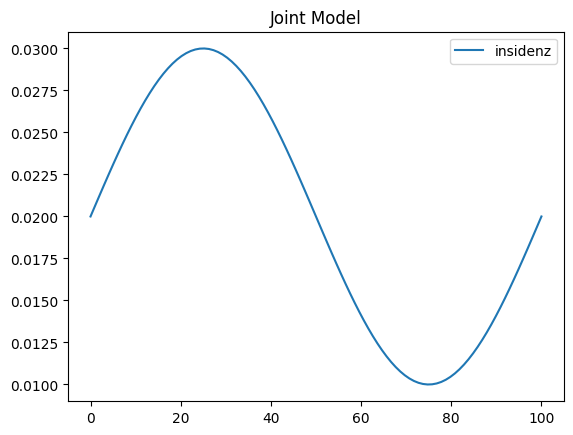

In [443]:
time = np.linspace(0, 100, 100)
plt.plot(time, insidenz(time), label='insidenz')
plt.title('Joint Model')
plt.legend()
plt.show()

# Estimation of the hazard function

In [ ]:
import itertools
from typing import Optional
from functools import partial
from bayesflow.simulation import Simulator
from inference.base_nlme_model import NlmeBaseAmortizer
from bayesflow import diagnostics

In [303]:
class linearModel(NlmeBaseAmortizer):
    def __init__(self, name: str = 'myModel'):
        # define names of parameters
        param_names = ['intercept', 'slope', 'error-variance']

        # define prior values (for log-parameters)
        prior_mean = np.array([np.log(2500), -3, -2])
        prior_cov = np.diag([1, 1, 0.1])
        self.prior_type = 'normal'

        super().__init__(name=name,
                         param_names=param_names,
                         prior_mean=prior_mean,
                         prior_cov=prior_cov)

        self.simulator = Simulator(batch_simulator_fun=partial(self.batch_simulator))
        
    # define simulator
    @staticmethod
    def batch_simulator(param_batch: np.ndarray, time: Optional[np.ndarray] = None, 
                        maxtime: int = 100, with_noise: bool = True) -> np.ndarray:
        param_batch = np.exp(param_batch)

        if param_batch.ndim == 1:  # so not (batch_size, params)
            # just a single parameter set
            param_batch = param_batch[np.newaxis, :]

        if time is None:
            n_measurements = np.random.randint(1, 5)
            time = np.random.uniform(1, maxtime, n_measurements)
            time.sort()

        # simulate data
        y = np.zeros((param_batch.shape[0], time.size, 2))
        for p_id, params in enumerate(param_batch):
            # model plus noise
            y[p_id, :, 0] = params[0] * np.exp(-params[1] * time)
            if with_noise:
                y[p_id, :, 0] *= ( 1 + params[2] * np.random.normal(loc=0, scale=1, size=time.size))
            y[p_id, :, 1] = time / maxtime

        # add censoring
        y[:, :, 0] = np.log(np.clip(y[:, :, 0], a_min=0.001, a_max=2500))
        return y
        
    def load_amortizer_configuration(self, model_idx: int = 0, load_best: bool = False) -> str:
        self.n_epochs = 10
        bidirectional_LSTM = [False]
        n_coupling_layers = [2, 3]
        n_dense_layers_in_coupling = [2]
        coupling_design = ['affine']
        summary_network_type = ['sequence']

        combinations = list(itertools.product(bidirectional_LSTM, n_coupling_layers,
                                              n_dense_layers_in_coupling, coupling_design, summary_network_type))

        (self.bidirectional_LSTM,
         self.n_coupling_layers,
         self.n_dense_layers_in_coupling,
         self.coupling_design,
         self.summary_network_type) = combinations[model_idx]

        model_name = f'amortizer-toyModel-{self.prior_type}' \
                     f'-{self.summary_network_type}-summary' \
                     f'-{"Bi-LSTM" if self.bidirectional_LSTM else "LSTM"}' \
                     f'-{self.n_coupling_layers}layers' \
                     f'-{self.n_dense_layers_in_coupling}coupling-{self.coupling_design}' \
                     f'-{self.n_epochs}epochs'
        return model_name
        
    def plot_example(self, params: Optional[np.ndarray] = None) -> None:
        raise NotImplementedError('Not implemented yet.')
        
    def prepare_plotting(self, data: np.ndarray, params: np.ndarray, ax: Optional[plt.Axes] = None) -> plt.Axes:
        raise NotImplementedError('Not implemented yet.')

In [304]:
toy_model = linearModel()

using 2 layers of MultiConv1D, a  LSTM with 256 units and a dense layer with output dimension 10 as summary network
using a 3-layer cINN as inference network with 2 layers of design affine
prior mean: [ 7.82404601 -3.         -2.        ]
prior covariance diagonal: [1.  1.  0.1]


In [ ]:
for i in range(10):
    prior_sample = toy_model.prior(1)['prior_draws']
    yt = toy_model.simulator(prior_sample)['sim_data']
    plt.plot(yt[0, :, 1], np.exp(yt[0, :, 0]))
plt.xlabel('time')
plt.ylabel('antibody')
plt.yscale('log')
plt.title('Simulated data')
plt.ylim(0.001, 2500)
plt.show()

In [ ]:
trainer = toy_model.build_trainer('../networks/' + toy_model.network_name)

In [ ]:
history = trainer.train_online(epochs=10,
                               iterations_per_epoch=100,
                               batch_size=128,
                               early_stopping=True,
                               validation_sims=100)

In [ ]:
new_sims = toy_model.generate_simulations_from_prior(trainer=trainer, n_samples=2500)
posterior_draws = toy_model.draw_posterior_samples(data=new_sims['summary_conditions'], n_samples=100)

In [ ]:
fig_sbc = diagnostics.plot_sbc_histograms(post_samples=posterior_draws,
                                          prior_samples=new_sims['parameters'],
                                          param_names=toy_model.log_param_names)

In [ ]:
from inference.helper_functions import create_mixed_effect_model_param_names

np.random.seed(42)
toy_samples = toy_model.prior(100)['prior_draws']
toy_samples[:, -2:] = toy_model.prior_mean[-2:]
toy_data = toy_model.simulator(toy_samples)['sim_data']

mixed_effect_params_names = create_mixed_effect_model_param_names(toy_model.param_names, 
                                                                  cov_type='diag')

In [ ]:
fixed_indices = np.array([4,5])
fixed_values = np.array([-np.log(0.001), -np.log(0.001)])

In [ ]:
from inference.inference_functions import run_population_optimization

result_optimization, obj_fun_amortized = run_population_optimization(
    individual_model=toy_model,
    data=toy_data,
    param_names=mixed_effect_params_names,
    cov_type='diag',
    n_multi_starts=10,
    n_samples_opt=100,
    covariates_bounds=None,
    covariates=None,
    n_covariates_params=0,
    covariate_mapping=None,
    x_fixed_indices=fixed_indices,
    x_fixed_vals=fixed_values,
    file_name=None, # f'../output/{model_name}-{cov_type}-n_data_{n_data}.hdf5',
    verbose=True,
    trace_record=True,
    pesto_multi_processes=10,
    result=None #result_optimization
    )

In [270]:
result_optimization.optimize_result.x[0]

array([ 7.30519607, -3.13236176, -1.93132648,  0.86787778,  6.90775528,
        6.90775528])

In [271]:
toy_samples.mean(axis=0), -np.log(toy_samples.var(axis=0))

/var/folders/6l/dj45z5dn7zn0djmp1vjb65bh0000gn/T/ipykernel_37338/2209455560.py:1: RuntimeWarning: divide by zero encountered in log
  toy_samples.mean(axis=0), -np.log(toy_samples.var(axis=0))


(array([ 7.6408127, -3.       , -2.       ]),
 array([0.05229324,        inf,        inf]))

In [272]:
# todo: then try to fit the hazard function with the joint model

In [449]:
# generate data
np.random.seed(42)

linear_pars = 2500, 0.03
hazard_pars = 10, 0.1
random_variance = 1
error_variance = 0.1

def hazard_function(beta, t, log_ad_t):
    return beta[0] * insidenz(t) * ( 1 - expit(beta[1] * log_ad_t ))

In [410]:
def generate_data():
    re = np.exp(np.random.normal(0, random_variance))
    log_params = np.log(np.array([linear_pars[0]*re, linear_pars[1], error_variance]))
    time = np.linspace(0, 100, 100)
    obs_data = toy_model.batch_simulator(log_params, time=time)[0]  # only return antibody data
    
    # get hazard function
    h_obs = hazard_function(hazard_pars, time, obs_data[:, 0])
    # sample infection event
    infection_event = np.random.uniform(0, 1, len(h_obs)) < h_obs
    infection_event_index = next((i for i, x in enumerate(infection_event) if x), None)
    if infection_event_index is None:
        event_is_censored = True
        infection_event_index = len(infection_event) - 1
    else:
        event_is_censored = False
    # cut of data
    obs_data = obs_data[:infection_event_index]
    # maximum of 4 measurements
    m_index = np.random.choice(len(time[:infection_event_index]), min(4, len(time[:infection_event_index])), replace=False)
    m_index.sort()
    return log_params, obs_data[m_index], time[m_index], time[infection_event_index], event_is_censored, h_obs

In [412]:
np.random.seed(42)
log_params_i, obs_data, time, infection_event, event_is_censored, h_obs = generate_data()
log_params_i, obs_data, time, infection_event, event_is_censored

(array([ 8.32076016, -3.5065579 , -2.30258509]),
 array([[7.82404601, 0.04040404],
        [7.82404601, 0.14141414],
        [7.21018919, 0.39393939],
        [6.26535292, 0.6969697 ]]),
 array([ 4.04040404, 14.14141414, 39.39393939, 69.6969697 ]),
 73.73737373737374,
 False)

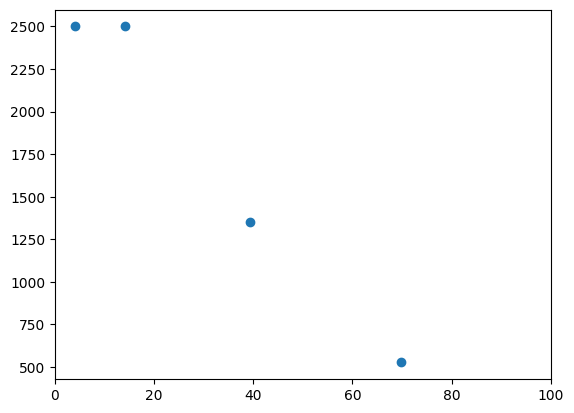

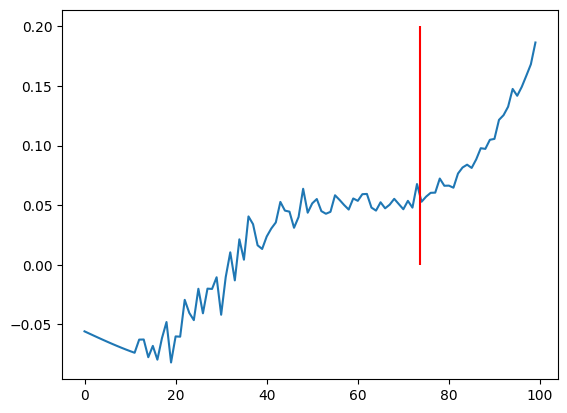

In [424]:
plt.scatter(time, np.exp(obs_data[:, 0]), label='antibody')
plt.xlim(0,100)
plt.show()
plt.plot(h_obs)
plt.vlines(infection_event, ymin=0, ymax=0.2, color='r')
plt.show()

In [401]:
import scipy.integrate as integrate

In [452]:
def log_hazard_term(evet_time_i, event_i_is_censored, hazard_pars, log_mixed_pars, batch_simulator):
    
    h_func = lambda t: float(hazard_function(hazard_pars, t, 
                                             log_ad_t=batch_simulator(log_mixed_pars, 
                                                             time=np.array([t]), 
                                                             with_noise=False)[0, :, 0]
                                             )
                             )
    integrand, err = integrate.quad(h_func, 0, evet_time_i)
    s = np.exp(-integrand)
    
    if event_i_is_censored:
        return np.log(s)
    else:
        return np.log(s * float(h_func(evet_time_i)))


In [453]:
log_hazard_term(infection_event, event_is_censored, hazard_pars, log_params_i, toy_model.batch_simulator)

-2.752786547058563